### This notebook trains an EffcientNet B4 model. This approach used single real valued ouput output which was mapped to between 0 and 1 using a sigmoid layer. 
The 0 to 1 range was split(unequally) to represent the target classes. A modified mean squared loss was used. This loss penalizes the model for producing an output distant from the central point of the target class range, using MSE. An additional heavier class loss is added to this MSE if the ouput lands in the range of a different class.

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
import pandas as pd
import numpy as np
import cv2

from efficientnet_pytorch import EfficientNet

In [2]:
class_boundaries = np.array([0.2655,0.3481,0.6782,0.7772])
class_centres = np.zeros(class_boundaries.shape[0]+1)
class_centres[0] = class_boundaries[0]/2
for i in range(1,class_boundaries.shape[0]):
    class_centres[i] = (class_boundaries[i]+class_boundaries[i-1])/2
class_centres[-1] = (1+class_boundaries[-1])/2
class_centres

array([0.13275, 0.3068 , 0.51315, 0.7277 , 0.8886 ])

In [3]:
df = pd.read_csv('../Data/train_labels.csv').fillna('')#.iloc[:100,:]

In [4]:
old_stats = ([0.7229, 0.6502, 0.6050], [0.1622, 0.1431, 0.1128])
def get_data(size=224,bs=32):
    np.random.seed(420)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))
    
    data = ImageDataBunch.from_df(
        '../Data/train_processed',
        df,
        ds_tfms=tfms,
        size=size,
        bs = bs,
        label_delim = ',',
        valid_pct = 0.1,
        num_workers = os.cpu_count() 
    ).normalize(old_stats)
    
    return data

In [19]:
data = get_data()

In [5]:
def get_class_stats():
    class_boundaries = torch.Tensor(np.array([0.2655,0.3481,0.6782,0.7772])).cuda()
    class_boundaries.requires_grad_(False)
    class_centres = torch.Tensor(np.array([0.13275, 0.3068 , 0.51315, 0.7277 , 0.8886 ])).cuda()
    class_centres.requires_grad_(False)
    return class_boundaries,class_centres

In [6]:
class OrdinalLoss(nn.Module):
    def __init__(self, phi):
        super().__init__()
        self.class_boundaries,self.class_centres = get_class_stats()
        self.phi = phi

    def forward(self, inputs, targets):
        # Classification error
        inputs = torch.sigmoid(inputs)
        inputs = inputs.reshape(inputs.shape[0],1)
        preds = (inputs-self.class_centres.reshape(1,self.class_centres.shape[0])).abs().argmin(-1)
        class_loss = torch.pow(self.phi,(targets.argmax(-1)-preds).abs().float()) - 1
        
        # Confidence error
        confidence_loss = torch.pow((self.class_centres[targets.argmax(-1)] - inputs.squeeze()),2)
         
        return (class_loss+confidence_loss).sum()

In [7]:
class ConfusionMatrixMultiClass(Callback):
    def on_train_begin(self, **kwargs):
        self.n_classes = 0
        self.class_boundaries, self.class_centres = get_class_stats()
        self.class_boundaries,self.class_centres = self.class_boundaries.cpu(),self.class_centres.cpu()

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        if self.n_classes == 0:
            self.n_classes = last_target.shape[-1]
            self.x = torch.arange(0, self.n_classes)  
        
        preds = torch.sigmoid(last_output).cpu()
        preds = (preds.reshape(preds.shape[0],1)-self.class_centres.reshape(1,self.class_centres.shape[0])).abs().argmin(-1)        
        targs = last_target.argmax(-1).cpu()
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        
@dataclass
class MultiKappaScore(ConfusionMatrixMultiClass):
    "Computes the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
#         raise ValueError()
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [8]:
from fastai.basic_train import LearnerCallback
from fastai.basic_train import Learner

class ControlPhi(LearnerCallback):
    """Stops model after N iterations.
    Usage:
    stopper = partial(StopAfterNIterations, num_iterations = 17)
    learn = create_cnn(data, models.resnet18, callback_fns = [stopper])
    """
    def __init__(self, learn: Learner):
        super().__init__(learn)

    def on_epoch_end(self, **kwargs) ->bool:
        if kwargs['epoch'] <= 20//2:
            if kwargs['epoch']%2 == 0:
                learn.loss_func.phi *= 1.05
                print('Changing phi to: '+str(learn.loss_func.phi))
        else:
            if kwargs['epoch']%2 == 0:
                learn.loss_func.phi *= 1.01
                print('Changing phi to: '+str(learn.loss_func.phi))

In [13]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1).cuda()
learn = Learner(get_data(416,16),
                model,
                wd=1e-5,
                callback_fns=[ShowGraph,
#                               OverSamplingCallback,
                              partial(SaveModelCallback, every='epoch', monitor='multi_kappa_score', name='epoch_num'),
                              partial(SaveModelCallback, every='improvement', monitor='multi_kappa_score', name='best_kappa', mode='max'),
#                               ControlPhi,
                              partial(AccumulateScheduler, n_step=2),
                              partial(ReduceLROnPlateauCallback, patience=2, min_delta=2e-3, factor=0.2, monitor='multi_kappa_score', mode='max')
                             ],
                metrics=[MultiKappaScore('quadratic')],
                loss_func = OrdinalLoss(phi=2.8)
               )
learn.to_fp16()
learn.load('epoch_num_9')
learn.unfreeze()

Loaded pretrained weights for efficientnet-b4


/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type OrdinalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [10]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B4_Uni', res=224, bs=16, div=25):
    learner.data = get_data(size=res,bs=bs)
    learner.to_fp16()
    learner.fit_one_cycle(epochs, lr, pct_start=0.3, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
0,8.650256,10.196739,0.629508,0.758980,04:17
1,10.945826,9.987151,0.593443,0.793104,04:11
2,9.712446,8.612100,0.575410,0.820977,04:02
3,10.485625,8.395123,0.570492,0.837821,04:10
4,9.385293,7.980297,0.572131,0.845731,04:06
5,8.538910,8.658279,0.580328,0.850683,04:06
6,8.844672,8.300161,0.601639,0.854898,04:07
7,10.498968,8.048925,0.611475,0.875256,04:04
8,9.755150,7.657297,0.606557,0.885269,04:07
9,8.353860,6.978411,0.609836,0.893266,04:04


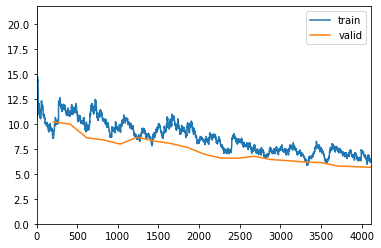

Better model found at epoch 0 with multi_kappa_score value: 0.7589799165725708.
Changing phi to: 2.1
Better model found at epoch 1 with multi_kappa_score value: 0.7931039333343506.
Better model found at epoch 2 with multi_kappa_score value: 0.8209771513938904.
Changing phi to: 2.205
Better model found at epoch 3 with multi_kappa_score value: 0.8378205299377441.
Better model found at epoch 4 with multi_kappa_score value: 0.8457305431365967.
Changing phi to: 2.3152500000000003
Better model found at epoch 5 with multi_kappa_score value: 0.8506833910942078.
Better model found at epoch 6 with multi_kappa_score value: 0.8548978567123413.
Changing phi to: 2.4310125000000005
Better model found at epoch 7 with multi_kappa_score value: 0.8752556443214417.
Better model found at epoch 8 with multi_kappa_score value: 0.8852687478065491.
Changing phi to: 2.3823922500000005
Better model found at epoch 9 with multi_kappa_score value: 0.8932664394378662.
Better model found at epoch 10 with multi_kappa_

In [25]:
do_fit(learn, 20, 3e-5, res=448, bs=16)

epoch,train_loss,valid_loss,multi_kappa_score,time
0,8.431895,5.745705,0.883835,04:29
1,8.148545,6.375456,0.880174,04:26
2,7.883711,6.268486,0.880989,04:22
3,8.954096,6.702879,0.881315,04:18
4,7.837585,6.304955,0.890676,04:21


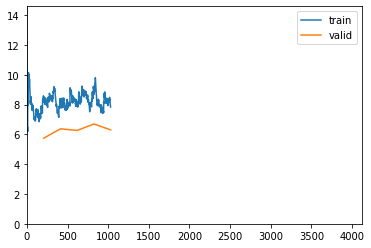

Better model found at epoch 0 with multi_kappa_score value: 0.8838346004486084.
Changing phi to: 2.1
Changing phi to: 2.205
Better model found at epoch 4 with multi_kappa_score value: 0.8906763792037964.
Changing phi to: 2.3152500000000003


In [ ]:
do_fit(learn, 20, 3e-5, res=448, bs=16)

Loaded epoch_num_8
Model best_kappa_8 not found.


epoch,train_loss,valid_loss,multi_kappa_score,time
9,8.317421,6.597594,0.914480,04:19
10,8.920136,6.865937,0.911536,04:17
11,10.183086,7.497656,0.911077,04:19
12,9.034582,7.570550,0.911739,04:21
13,10.035372,7.780822,0.911092,04:21
14,8.794998,7.779869,0.910941,04:22
15,10.856819,7.540301,0.913963,04:24
16,10.606225,7.994340,0.909889,04:25
17,9.138350,8.290196,0.909271,04:22
18,9.389002,8.290595,0.909271,04:24


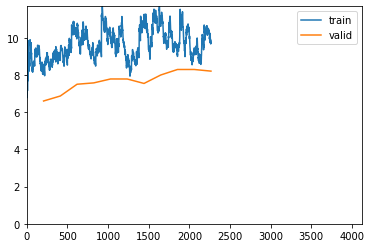

Better model found at epoch 9 with multi_kappa_score value: 0.9144799113273621.
Changing phi to: 2.68019115
Changing phi to: 2.7069930615000004
Changing phi to: 2.7340629921150006
Changing phi to: 2.7614036220361506
Changing phi to: 2.7890176582565123


RuntimeError: write(): fd 67 failed with No space left on device

In [11]:
do_fit(learn, 20, 3e-5, res=448, bs=16, start_epoch=9)

## Extra fit

In [12]:
def do_fit_extra(learner, epochs, lr, start_epoch=0, name='B4_Uni', res=224, bs=16):
    learner.data = get_data(size=res,bs=bs)
    learner.to_fp16()
    learner.fit(epochs, lr)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,multi_kappa_score,time
0,11.001279,9.250175,0.895165,04:14
1,10.587519,9.169651,0.896606,04:05
2,11.311834,9.249010,0.895475,04:14
3,10.286309,9.248538,0.894978,04:07
4,10.299790,9.090596,0.897247,04:12
5,11.428342,9.090428,0.897247,03:59
6,10.907657,9.248673,0.895475,04:02
7,11.529414,9.169060,0.896115,03:57
8,9.944343,9.247245,0.895599,04:00
9,10.543492,9.247137,0.895968,04:00


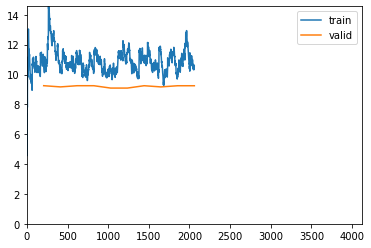

Better model found at epoch 0 with multi_kappa_score value: 0.8951646089553833.
Better model found at epoch 1 with multi_kappa_score value: 0.8966056704521179.
Epoch 3: reducing lr to 1.0000000000000002e-06
Better model found at epoch 4 with multi_kappa_score value: 0.897246778011322.
Epoch 7: reducing lr to 2.0000000000000004e-07


KeyboardInterrupt: 

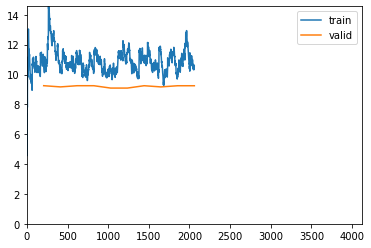

In [22]:
do_fit_extra(learn, 20, 5e-6, start_epoch=20, res=448, bs=16)

epoch,train_loss,valid_loss,multi_kappa_score,time
0,11.169229,8.884100,0.899432,04:12
1,14.211684,9.122427,0.895455,04:08
2,11.552062,8.822320,0.899304,04:15
3,11.406151,8.963841,0.897506,04:08
4,11.403518,8.585292,0.902529,03:55
5,11.432920,8.822004,0.899304,04:06
6,13.264852,9.122723,0.895267,03:52
7,11.266026,8.742799,0.900322,04:06
8,11.701708,8.663963,0.901399,04:04
9,12.133908,8.662694,0.901869,04:09


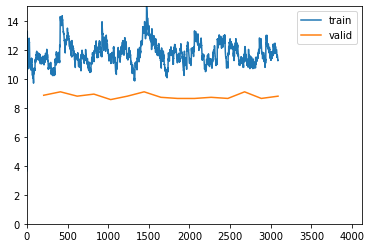

Better model found at epoch 0 with multi_kappa_score value: 0.8994324207305908.
Epoch 3: reducing lr to 4e-08
Better model found at epoch 4 with multi_kappa_score value: 0.9025287628173828.
Epoch 7: reducing lr to 8e-09
Epoch 10: reducing lr to 1.6000000000000003e-09
Epoch 13: reducing lr to 3.200000000000001e-10


KeyboardInterrupt: 

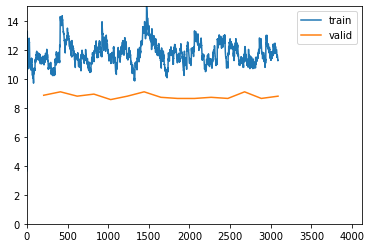

In [12]:
do_fit_extra(learn, 20, 2e-7, start_epoch=20, res=448, bs=16)

epoch,train_loss,valid_loss,multi_kappa_score,time
0,11.146822,7.640760,0.915965,04:21
1,10.705684,7.796498,0.914480,04:23
2,9.792923,7.875119,0.913517,04:15
3,11.323055,7.874965,0.913517,04:19
4,11.240178,7.718600,0.915148,04:20
5,11.237528,7.875172,0.913517,04:17
6,11.300556,7.953372,0.913153,04:18
7,11.246408,7.797142,0.914480,04:18


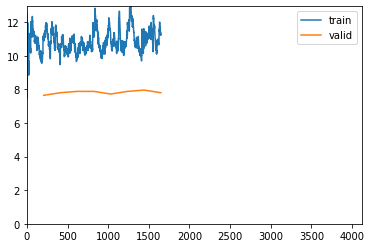

Better model found at epoch 0 with multi_kappa_score value: 0.9159648418426514.
Epoch 3: reducing lr to 4e-08
Epoch 6: reducing lr to 8e-09


KeyboardInterrupt: 

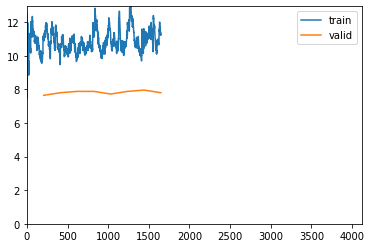

In [14]:
do_fit_extra(learn, 20, 2e-7, start_epoch=20, res=448, bs=16)

In [15]:
learn.loss_func = None
learn.metrics = []
learn.callbacks = [] 

In [16]:
learn.export()

In [3]:
learn = load_learner('/home/atom/Data/train_processed')

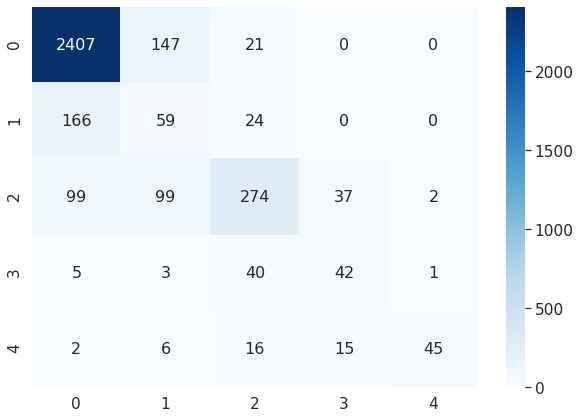

In [86]:
cm = np.array([
        [2.4070e+03, 1.4700e+02, 2.1000e+01, 0.0000e+00, 0.0000e+00],
        [1.6600e+02, 5.9000e+01, 2.4000e+01, 0.0000e+00, 0.0000e+00],
        [9.9000e+01, 9.9000e+01, 2.7400e+02, 3.7000e+01, 2.0000e+00],
        [5.0000e+00, 3.0000e+00, 4.0000e+01, 4.2000e+01, 1.0000e+00],
        [2.0000e+00, 6.0000e+00, 1.6000e+01, 1.5000e+01, 4.5000e+01]],dtype=np.int32)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
       
df_cm = pd.DataFrame(cm, range(5),range(5))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='Blues',fmt='d')# font size
# cm

In [23]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
!sudo shutdown -h 1